In [1]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git


Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 0 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 17.27 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


In [2]:
# Resolve Deps issue
!pip install segmentation-models-pytorch  # For UNet and SegNet
!pip install ultralytics  # For YOLOv11

# Import Libs
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from segmentation_models_pytorch import Unet  # For UNet and SegNet
from ultralytics import YOLO  # For YOLOv11

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Define paths
dataset_path = '/content/PlantVillage-Dataset/raw/color'

# Get list of all images and their labels
images = []
labels = []
class_names = os.listdir(dataset_path)
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Fix the total number of samples per class to 500
fixed_samples_per_class = 500

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    img_paths = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)]

    # Randomly sample 500 images per class (or take all if fewer)
    img_paths = random.sample(img_paths, min(len(img_paths), fixed_samples_per_class))

    images.extend(img_paths)
    labels.extend([class_to_idx[class_name]] * len(img_paths))

# Split the dataset into training (60%), validation (20%), and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2






class PlantVillageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = cv2.resize(image, (224, 224))  # Resize to 224x224
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create datasets
train_dataset = PlantVillageDataset(X_train, y_train, transform=transform)
val_dataset = PlantVillageDataset(X_val, y_val, transform=transform)
test_dataset = PlantVillageDataset(X_test, y_test, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train Samples: {len(train_dataset)}, Val Samples: {len(val_dataset)}, Test Samples: {len(test_dataset)}")



Train Samples: 10746, Val Samples: 3582, Test Samples: 3582


In [4]:
def train_model(model_name, train_loader, val_loader, test_loader, num_classes, num_epochs=5):
    # Load pre-trained model (smallest versions)
    if model_name == 'VGG':
        model = models.vgg11(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'ResNet':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'InceptionV3':
        model = models.inception_v3(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'EfficientNetV2':
        model = models.efficientnet_v2_s(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'ViT':
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif model_name == 'AlexNet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'GoogleNet':
        model = models.googlenet(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'UNet':
        model = Unet(encoder_name='resnet18', encoder_weights='imagenet', classes=num_classes, activation='softmax')
    elif model_name == 'SegNet':
        model = SegNet(encoder_name='resnet18', encoder_weights='imagenet', classes=num_classes, activation='softmax')
    elif model_name == 'YOLOv11':
        model = YOLO('yolov11n.pt')  # Smallest version of YOLOv11
    else:
        raise ValueError("Model not supported")

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Plot training and validation accuracy
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluate on test set
    model.eval()
    y_true, y_scores = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs)

    # Plot PR curves for top-N classes
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    top_n = 5
    ap_scores = []

    for class_idx in range(num_classes):
        average_precision = average_precision_score(y_true == class_idx, y_scores[:, class_idx])
        ap_scores.append((class_idx, average_precision))

    top_classes = sorted(ap_scores, key=lambda x: x[1], reverse=True)[:top_n]

    plt.figure(figsize=(10, 8))
    for class_idx, average_precision in top_classes:
        precision, recall, _ = precision_recall_curve(y_true == class_idx, y_scores[:, class_idx])
        plt.plot(recall, precision, label=f'Class {class_idx} (AP={average_precision:.2f})')

    plt.title(f'{model_name} Precision-Recall Curve (Top-{top_n} Classes)', fontsize=16)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return model


Training ViT...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 68.8MB/s]


Epoch 1/10, Train Loss: 2.5690, Train Acc: 27.19%, Val Loss: 1.4622, Val Acc: 54.94%
Epoch 2/10, Train Loss: 1.1845, Train Acc: 63.38%, Val Loss: 0.8500, Val Acc: 72.72%
Epoch 3/10, Train Loss: 0.7885, Train Acc: 74.84%, Val Loss: 0.6984, Val Acc: 77.55%
Epoch 4/10, Train Loss: 0.5953, Train Acc: 80.91%, Val Loss: 0.6206, Val Acc: 78.73%
Epoch 5/10, Train Loss: 0.4423, Train Acc: 85.59%, Val Loss: 0.4347, Val Acc: 85.68%
Epoch 6/10, Train Loss: 0.4079, Train Acc: 86.23%, Val Loss: 0.4747, Val Acc: 84.28%
Epoch 7/10, Train Loss: 0.3643, Train Acc: 88.14%, Val Loss: 0.4528, Val Acc: 85.87%
Epoch 8/10, Train Loss: 0.2940, Train Acc: 90.08%, Val Loss: 0.4145, Val Acc: 87.05%
Epoch 9/10, Train Loss: 0.2679, Train Acc: 90.97%, Val Loss: 0.4047, Val Acc: 87.52%
Epoch 10/10, Train Loss: 0.2269, Train Acc: 92.10%, Val Loss: 0.4050, Val Acc: 87.16%


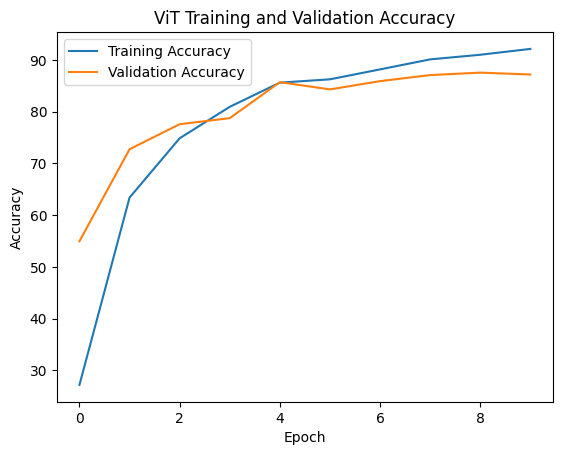

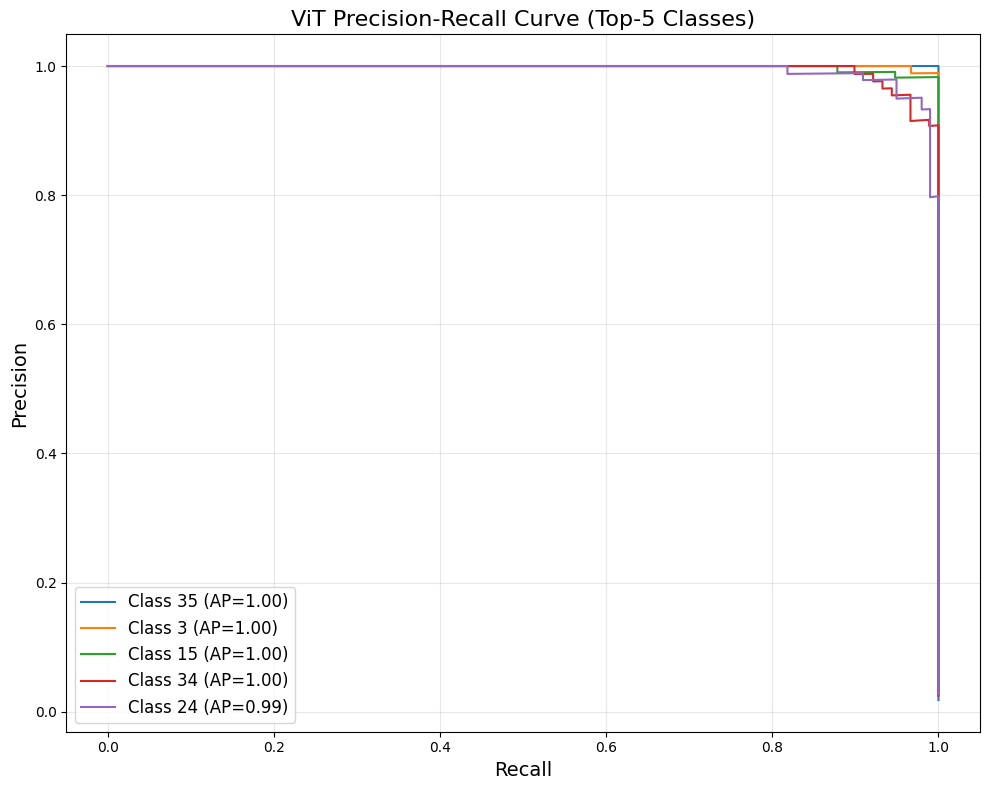

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Training GoogleNet...


100%|██████████| 49.7M/49.7M [00:00<00:00, 155MB/s]


Epoch 1/10, Train Loss: 0.5772, Train Acc: 83.49%, Val Loss: 0.2759, Val Acc: 91.04%
Epoch 2/10, Train Loss: 0.2143, Train Acc: 93.18%, Val Loss: 0.1116, Val Acc: 96.48%


In [ ]:
models_list = [ 'ViT',  'GoogleNet', 'UNet']

num_classes = len(class_names)

# Train all models
for model_name in models_list:
    print(f'Training {model_name}...')
    model = train_model(model_name, train_loader, val_loader, test_loader, num_classes, num_epochs=10)